# Why Deep Learning for Recommendation - Colaborative Filtering

![DL](https://miro.medium.com/max/1400/0*TUQwLXi6E136S8bQ.png)

With the massive amounts of data being produced by the current "Big Data Era", Deep Learning is gaining much popularity due to it's supremacy in terms of accuracy when trained with huge amount of data.

* Deep Learning (with fine-tuning) usually out-perform traditional Machine Learning if the data size is large.
* But with small data size, traditional Machine Learning algorithms are preferable.

> ### The analogy to deep learning is that the rocket engine is the deep learning models and the fuel is the huge amounts of data we can feed to these algorithms - Andrew Ng

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

# We can applied Deep Learning to RECOMMENDATION SYSTEMS

* Neural nets are fundamentally matrix operations.
* Matrix factorization techniques for recommendation systems also doing something similar.
* For example: in SVD, We find matrices using weights calculated by SGD, Which is similar to Deep Learning
* Even though by small margins, in some researches Deep Learning can outperformed SVD!

> ## If you want to make an application, you will definitely use huge data, especially in Recommendation System World..

In [2]:
reviews = pd.read_csv('/kaggle/input/movielens-1m/ml-1m/ratings.dat', names=['userId', 'movieId', 'rating', 'time'], delimiter='::', engine='python')
users = pd.read_csv('/kaggle/input/movielens-1m/ml-1m/users.dat', names=['userId','gender','age','occupation','zip'], delimiter='::', engine='python')
movies = pd.read_csv('/kaggle/input/movielens-1m/ml-1m/movies.dat', names=['movieId', 'Movie_names', 'Genres'], delimiter='::', engine='python')

print('Reviews shape:', reviews.shape)
print('Users shape:', users.shape)
print('Movies shape:', movies.shape)

Reviews shape: (1000209, 4)
Users shape: (6040, 5)
Movies shape: (3883, 3)


In [3]:
reviews.drop(['time'], axis=1, inplace=True)
users.drop(['zip'], axis=1, inplace=True)

In [4]:
movies['release_year'] = movies['Movie_names'].str.extract(r'(?:\((\d{4})\))?\s*$', expand=False)

### Merging all dataset

In [5]:
final_df = reviews.merge(movies, on='movieId', how='left').merge(users, on='userId', how='left')

print('Final_df shape:', final_df.shape)

Final_df shape: (1000209, 9)


In [6]:
final_df.head()

,userId,movieId,rating,Movie_names,Genres,release_year,gender,age,occupation
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama,1975,F,1,10
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical,1996,F,1,10
2,1,914,3,My Fair Lady (1964),Musical|Romance,1964,F,1,10
3,1,3408,4,Erin Brockovich (2000),Drama,2000,F,1,10
4,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,F,1,10


# Collaborative Filtering - Deep Learning

1. One important thing to keep in mind is that in an approach based purely on collaborative filtering, the similarity is not calculated using factors like the age of users, genre of the movie, or any other data about users or items.
1. It is calculated only on the basis of the rating (explicit or implicit) a user gives to an item.
1. For example, two users can be considered similar if they give the same ratings to ten movies despite there being a big difference in their age.

In [7]:
userid_nunique = final_df['userId'].nunique()
movieid_nunique = final_df['movieId'].nunique()

print('User_id total unique:', userid_nunique)
print('Movieid total unique:', movieid_nunique)

User_id total unique: 6040
Movieid total unique: 3706


## To build our first collaborative filtering model, we need to take care of a few things first:

1. The user / movie features are currently non-sequential integers representing some unique ID for that entity
1. We need them to be sequential **starting at zero** to use for modeling (if not, it will throw an error)
1. We can use scikit-learn’s LabelEncoder class to transform the fields
1. Finally, We’ll also create variables with the total number of unique users and movies in the data

In [8]:
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
final_df['userId'] = user_enc.fit_transform(final_df['userId'])

movie_enc = LabelEncoder()
final_df['movieId'] = movie_enc.fit_transform(final_df['movieId'])

In [9]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

## Model 1

In [36]:
# Notes: Reshape(n_dim, ) is same with Flatten, we can use both (choose one)

def RecommenderV1(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Movie
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    
    # Dot U and M
    x = Dot(axes=1)([U, M])
    
    model = Model(inputs=[user, movie], outputs=x)
    
    model.compile(optimizer=Adam(0.0001),
                  loss='mean_squared_error')
    
    return model

In [37]:
model1 = RecommenderV1(userid_nunique, movieid_nunique, 100)

### Model1 - plot and summary

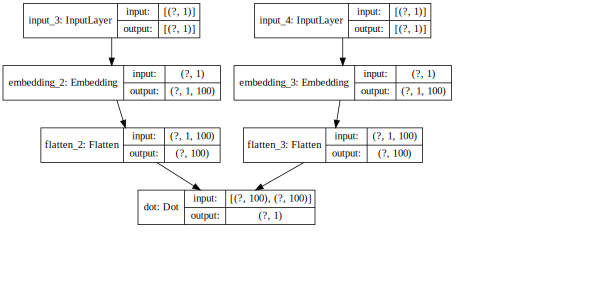

In [38]:
SVG(model_to_dot(model1,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [39]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       604000      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       370600      input_4[0][0]                    
____________________________________________________________________________________________

## Notes: Train test split

* This is VERY IMPORTANT part, if we don't use train_test_split (with stratify), val_loss will not decrease (stuck) during training

In [10]:
from sklearn.model_selection import train_test_split

X = final_df.drop(['rating'], axis=1)
y = final_df['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((900188, 8), (100021, 8), (900188,), (100021,))

### Let's train model 1

In [40]:
checkpoint1 = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [41]:
history1 = model1.fit(x=[X_train['userId'], X_train['movieId']], y=y_train, batch_size=64, epochs=10, verbose=1, validation_data=([X_val['userId'], X_val['movieId']], y_val), callbacks=[checkpoint1])

Train on 900188 samples, validate on 100021 samples
Epoch 1/10
900188/900188 [==============================] - 78s 86us/sample - loss: 12.8801 - val_loss: 8.0105
Epoch 2/10
900188/900188 [==============================] - 79s 88us/sample - loss: 3.3564 - val_loss: 1.5380
Epoch 3/10
900188/900188 [==============================] - 75s 84us/sample - loss: 1.1811 - val_loss: 0.9946
Epoch 4/10
900188/900188 [==============================] - 76s 85us/sample - loss: 0.9205 - val_loss: 0.8831
Epoch 5/10
900188/900188 [==============================] - 76s 85us/sample - loss: 0.8585 - val_loss: 0.8508
Epoch 6/10
900188/900188 [==============================] - 77s 86us/sample - loss: 0.8359 - val_loss: 0.8355
Epoch 7/10
900188/900188 [==============================] - 78s 87us/sample - loss: 0.8213 - val_loss: 0.8242
Epoch 8/10
900188/900188 [==============================] - 77s 85us/sample - loss: 0.8073 - val_loss: 0.8127
Epoch 9/10
900188/900188 [==============================] - 77s 86u

### Model 1 Evaluation

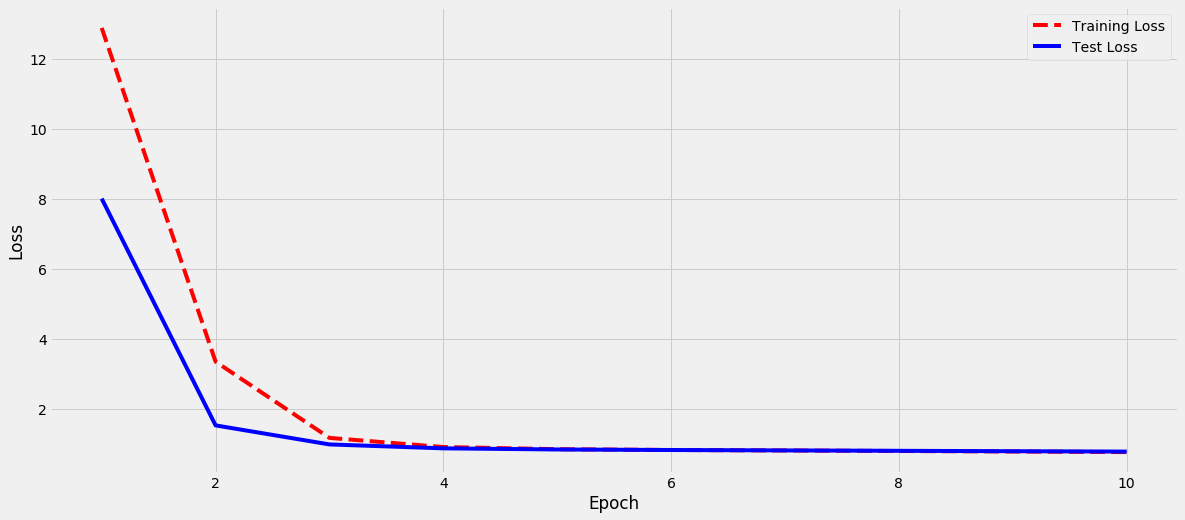

In [42]:
# Get training and test loss histories
training_loss1 = history1.history['loss']
test_loss1 = history1.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss1) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss1, 'r--')
plt.plot(epoch_count, test_loss1, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Model 2

In [11]:
## Notes: Reshape(n_dim, ) is same with Flatten, we can use both (choose one)

def RecommenderV2(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Movie
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    
    # Ganti disini
    merged_vector = concatenate([U, M])
    dense_1 = Dense(128, activation='relu')(merged_vector)
    dropout = Dropout(0.5)(dense_1)
    final = Dense(1)(dropout)
    
    model = Model(inputs=[user, movie], outputs=final)
    
    model.compile(optimizer=Adam(0.001),
                  loss='mean_squared_error')
    
    return model

In [12]:
model2 = RecommenderV2(userid_nunique, movieid_nunique, 100)

### Model2 - plot and summary

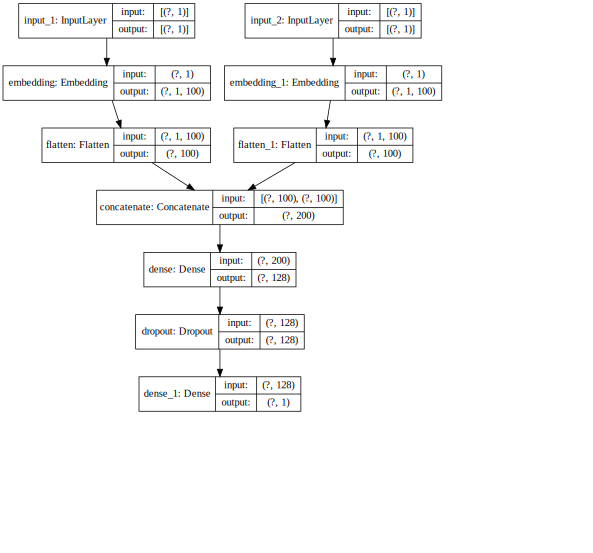

In [13]:
SVG(model_to_dot(model2,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [14]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       604000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       370600      input_2[0][0]                    
______________________________________________________________________________________________

In [15]:
checkpoint2 = ModelCheckpoint('model2.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [16]:
history2 = model2.fit(x=[X_train['userId'], X_train['movieId']], y=y_train, batch_size=64, epochs=20,
                      verbose=1, validation_data=([X_val['userId'], X_val['movieId']], y_val), callbacks=[checkpoint2])

Train on 900188 samples, validate on 100021 samples
Epoch 1/20
900188/900188 [==============================] - 86s 95us/sample - loss: 1.0171 - val_loss: 0.8223
Epoch 2/20
900188/900188 [==============================] - 85s 95us/sample - loss: 0.8285 - val_loss: 0.7943
Epoch 3/20
900188/900188 [==============================] - 85s 94us/sample - loss: 0.8017 - val_loss: 0.7793
Epoch 4/20
900188/900188 [==============================] - 83s 93us/sample - loss: 0.7873 - val_loss: 0.7794
Epoch 5/20
900188/900188 [==============================] - 83s 93us/sample - loss: 0.7786 - val_loss: 0.7714
Epoch 6/20
900188/900188 [==============================] - 84s 94us/sample - loss: 0.7723 - val_loss: 0.7674
Epoch 7/20
900188/900188 [==============================] - 84s 93us/sample - loss: 0.7662 - val_loss: 0.7695
Epoch 8/20
900188/900188 [==============================] - 83s 93us/sample - loss: 0.7591 - val_loss: 0.7647
Epoch 9/20
900188/900188 [==============================] - 83s 92us

### Model 2 Evaluation

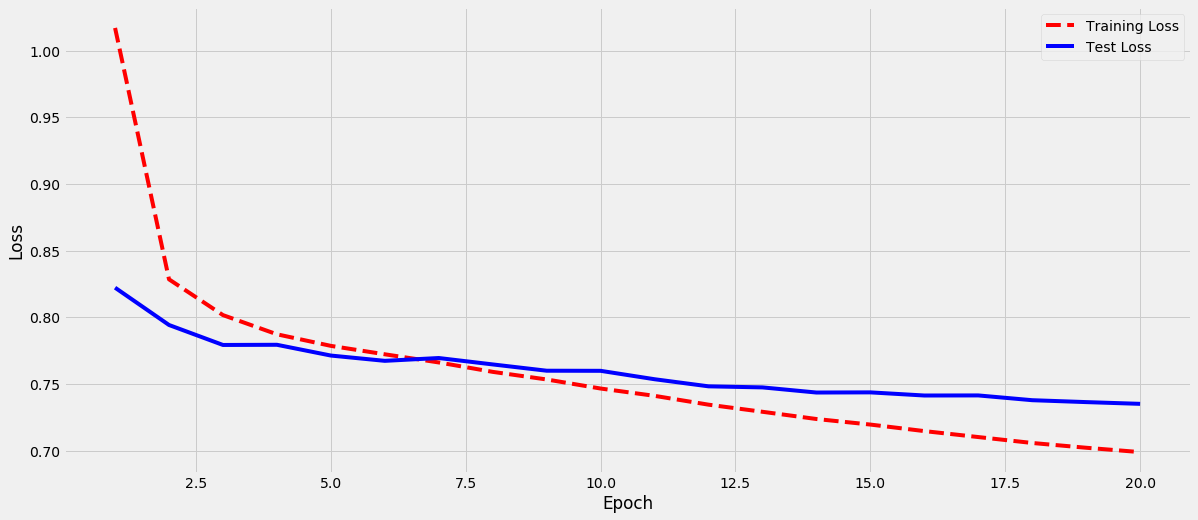

In [17]:
# Get training and test loss histories
training_loss2 = history2.history['loss']
test_loss2 = history2.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss2) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss2, 'r--')
plt.plot(epoch_count, test_loss2, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Model 3

In [48]:
# Notes: Reshape(n_dim, ) is same with Flatten, we can use both (choose one)

def RecommenderV3(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    U = Dense(64, activation='relu')(U)
    
    # Movie
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    M = Dense(64, activation='relu')(M)
    
    # Dot U and M
    x = concatenate([U, M])
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    final = Dense(1)(x)
    
    model = Model(inputs=[user, movie], outputs=final)
    
    model.compile(optimizer=Adam(0.0001),
                  loss='mean_squared_error')
    
    return model

In [49]:
model3 = RecommenderV3(userid_nunique, movieid_nunique, 100)

### Model 3 - plot and summary

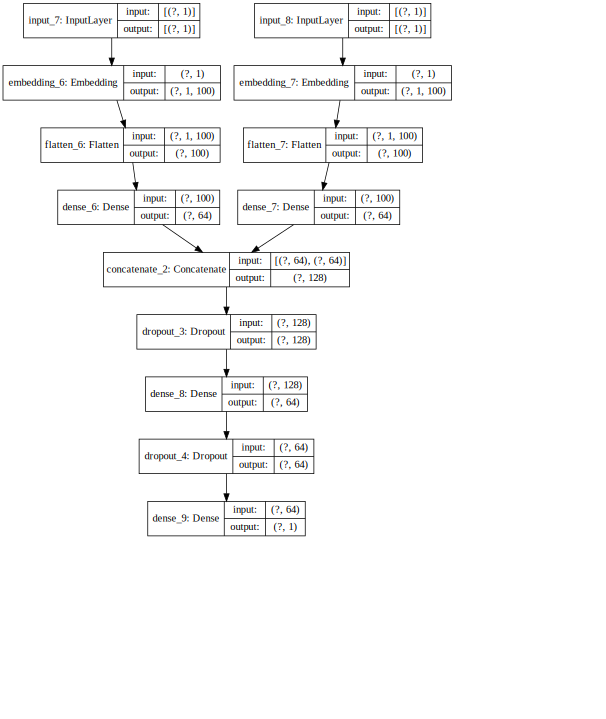

In [50]:
SVG(model_to_dot(model3,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [51]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 100)       604000      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 100)       370600      input_8[0][0]                    
____________________________________________________________________________________________

In [47]:
checkpoint3 = ModelCheckpoint('model3.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [52]:
history3 = model3.fit(x=[X_train['userId'], X_train['movieId']], y=y_train, batch_size=64, epochs=20,
                      verbose=1, validation_data=([X_val['userId'], X_val['movieId']], y_val), callbacks=[checkpoint3])

Train on 900188 samples, validate on 100021 samples
Epoch 1/20
900188/900188 [==============================] - 85s 94us/sample - loss: 1.4939 - val_loss: 0.8473
Epoch 2/20
900188/900188 [==============================] - 85s 94us/sample - loss: 1.0649 - val_loss: 0.8333
Epoch 3/20
900188/900188 [==============================] - 86s 96us/sample - loss: 0.9617 - val_loss: 0.8206
Epoch 4/20
900188/900188 [==============================] - 85s 94us/sample - loss: 0.8972 - val_loss: 0.8088
Epoch 5/20
900188/900188 [==============================] - 84s 93us/sample - loss: 0.8582 - val_loss: 0.8031
Epoch 6/20
900188/900188 [==============================] - 86s 96us/sample - loss: 0.8366 - val_loss: 0.7983
Epoch 7/20
900188/900188 [==============================] - 92s 103us/sample - loss: 0.8243 - val_loss: 0.7975
Epoch 8/20
900188/900188 [==============================] - 85s 94us/sample - loss: 0.8161 - val_loss: 0.7940
Epoch 9/20
900188/900188 [==============================] - 85s 94u

### Model 3 - evaluation

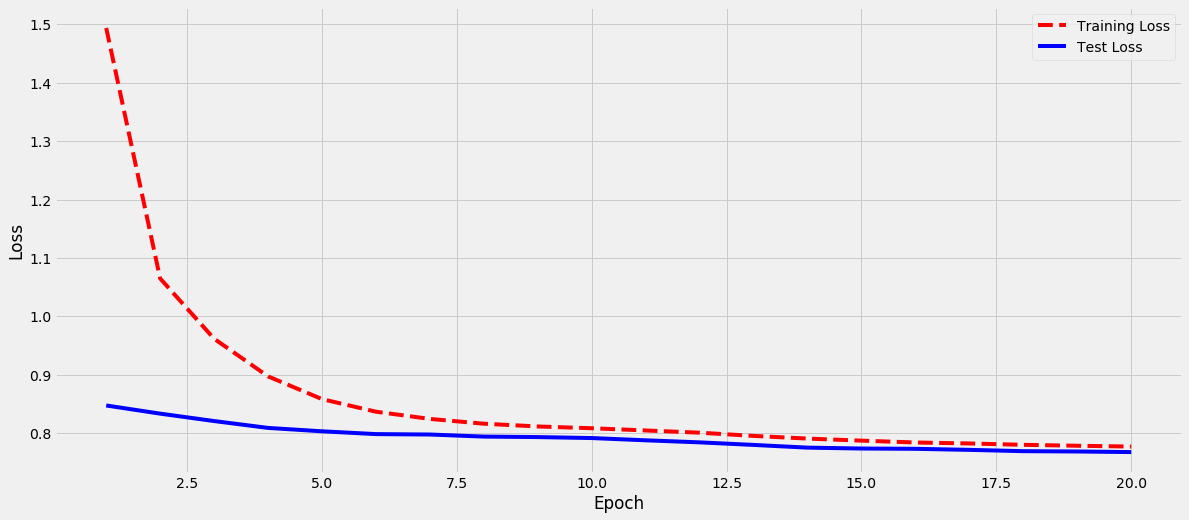

In [53]:
# Get training and test loss histories
training_loss3 = history3.history['loss']
test_loss3 = history3.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss3) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss3, 'r--')
plt.plot(epoch_count, test_loss3, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

* As you see, Deep Learning needs us to spend time for hyperparameter tuning & training
* After you have experience, it will not be too difficult

> ### We can increase model accuracy by change the hyper-parameter, increase epochs, tuning a optimizer, learning rate & batch-size. I leave this to be homework for you

## Let's compare Top-N recommendation made by all three models

> ### Note: It'll take a quite long time to predict, compare to SVD with scikit-surprise

In [54]:
from tensorflow.keras.models import load_model

model1 = load_model('model1.h5')
model2 = load_model('model2.h5')
model3 = load_model('model3.h5')

In [61]:
def make_pred(user_id, movie_id, model):
    return model.predict([np.array([user_id]), np.array([movie_id])])[0][0]

In [62]:
def get_topN_rec(user_id, model):
    
    user_ratings = final_df[final_df['userId'] == user_id][['userId', 'movieId', 'rating']]
    recommendation = final_df[~final_df['movieId'].isin(user_ratings['movieId'])][['movieId']].drop_duplicates()
    recommendation['rating_predict'] = recommendation.apply(lambda x: make_pred(user_id, x['movieId'], model), axis=1)
    
    final_rec = recommendation.sort_values(by='rating_predict', ascending=False).merge(movies[['movieId', 'Movie_names', 'release_year']],
                                                                       on='movieId',
                                                                       how='inner').head(10)
    
    return final_rec.sort_values('release_year', ascending=False).drop(['movieId', 'release_year'], axis=1)  # sort by recent year

### Model 1

In [64]:
get_topN_rec(23, model1)

,rating_predict,Movie_names
5,4.778392,Love Stinks (1999)
3,4.782286,My Giant (1998)
0,4.908134,Zone 39 (1997)
1,4.795276,"Eighth Day, The (Le Huiti�me jour ) (1996)"
2,4.783218,Mission: Impossible (1996)
8,4.749095,Plutonium Circus (1995)
7,4.754008,Supercop (1992)
9,4.729610,Dead Calm (1989)
4,4.778883,Platoon (1986)
6,4.769419,Places in the Heart (1984)


### Model 3

In [63]:
get_topN_rec(23, model3)

,rating_predict,Movie_names
0,4.672012,"Inheritors, The (Die Siebtelbauern) (1998)"
2,4.619383,My Giant (1998)
1,4.644605,Zone 39 (1997)
8,4.592476,Mission: Impossible (1996)
7,4.592824,Plutonium Circus (1995)
5,4.599246,Guardian Angel (1994)
9,4.589554,Of Love and Shadows (1994)
3,4.609591,Platoon (1986)
6,4.594595,"Funhouse, The (1981)"
4,4.603675,Shall We Dance? (1937)


* Remember that offline metrics such as accuracy, diversity, and novelty can all be indicators you can look at while developing Recommendation Systems offline but never declare victory until you measure real impact on real users.
* There is a real challenge where often accuracy metrics tell your algorithm is great only to have it do HORRIBLE in online A/B Test.

> ### There is more art than science in the development of Recommendation Systems

# More about Collaborative Filtering - pros-cons

### Pros

* Collaborative filtering can help recommenders to not overspecialize in a user’s profile and recommend items that are completely different from what they have seen before.
* If you want your recommender to not suggest a pair of sneakers to someone who just bought another similar pair of sneakers, then try to add collaborative filtering to your recommender spell.

### Cons

* Collaborative filtering can lead to some problems like cold start for new items that are added to the list. Until someone rates them, they don’t get recommended.

* Data sparsity can affect the quality of user-based recommenders and also add to the cold start problem mentioned above.

* Scaling can be a challenge for growing datasets as the complexity can become too large. Item-based recommenders are faster than user-based when the dataset is large.

* With a straightforward implementation, you might observe that the recommendations tend to be already popular, and the items from the long tail section might get ignored.

# Reference

[Deep Learning for Movie Recommendation](https://github.com/khanhnamle1994/movielens/blob/master/Deep_Learning_Model.ipynb)